# ICRA 2022 Tutorial 3, Insufficient Data (2D Range-only)

**Keywords:** Range-only, factor graph, under-determined, localization, mapping, SLAM, missing data, insufficient data, robotics, inference, Bayes tree, junction tree

![Example Overview](../../static/icra-3/example-wifi.png)

## Overview

- This example shows how non-Gaussian solutions (i.e. singular solutions) from having too few data given the desired system variables.
- In 2D on a flat plane, we imagine a robot traveling around in a rectangular trajectory making range measurements to beacons -- let's say WiFi power level is used as a proxy for range in this case.
- To illustrate the the underdetermined solution aspect, lets simplify the problem in that WiFi ranging (i.e. power level) is assumed as a pure unimodal (Gaussian) measurement.
- The non-Gaussian behavior will arise because we have more variables than measurement dimensions throughout the entire problem.
- The factor graph system will be built up in stages as the robot moves around the environment, which we will all pose/keyframe epochs.
- A new factor graph solve will be performed at each pose epoch, which produces the posterior marginal beliefs on each of the variables in the system.
- We assume the robot is traveling on a XY plane (viewing top down), starting at the origin along X and turning left along Y, then negative X, negative Y back to the origin. 
- Only four WiFi beacons are in the environment where the robot is moving.
- Measurements to the WiFj beacons can only be included with there if the signal is within range.
- Two of the beacon locations are known as prior information, while the other two beacons are at an unknown location and their location will be eastimated simultaneously to the robot pose location in the same factor graph system -- making this a minimalal simultaneous localization and mapping (SLAM) problem.
- To further simplify the tutorial, a range-only (i.e. distance-only) "odometry" measurement will be used between consecutive poses.  These "odometry" factors provide less information than conventional wheel or visual odometry constraints might provide.
- The tutorial is designed in such a way that the number of variable dimensions always exceed the measurement dimensions.
- After each pose epoch solution, we will look at the marginal belief estimates of all the variables in the system.
- This tutorial shows one of four mechanisms that can intoduce non-Gaussian behavior into a factor graph system, see other examples for other mechanisms.
- Optional, replace pure Gaussian measurement ranging models with ambiguous measurements shown in ICRA Tutorial 2.
- Optional, incorporate uncertain data association (i,e. multi-hypothesis) measurement models for unknown beacon associations similat to the technique used in ICRA Tutorial 4.
- Learn more from our peer-reviewed publications listed here: `CJLDocs/Literature`

### Signatures Used

`Point2`, `PriorPoint2`, `Point2Point2Range`, `MvNormal`, `Normal`.

## Loading The Data

The ground truth positions for vehicle positions GTp and landmark positions GTl can be loaded into memory directly with these values.  **Note,** we are using variable names
- `l1, l2` as ranging beacons with known locations,
- `l3, l4` as ranging beacons with initially unknown locations,  

These beacon landmarks must be in range before measurements can be made to them.  For the tutorial, we imagine a robot moving from one position to the next in the XY space between the landmarks.  We use ground truth positions to build the simulation, while the SLAM solution has to resolve estimates of the variables as the main exercise of the tutorial.  The robot positions are denoted as
- `x0, x1, ...`.

Ground truth data is as follows:

In [3]:
# Our dictionary of vehicle positions
GTp = Dict{Symbol, Vector{Float64}}()
GTp[:x0] = [0.0;0]
GTp[:x1] = [50.0;0]
GTp[:x2] = [100.0;0]
GTp[:x3] = [100.0;50.0]
GTp[:x4] = [100.0;100.0]
GTp[:x5] = [50.0;100.0]
GTp[:x6] = [0.0;100.0]
GTp[:x7] = [0.0;50.0]
GTp[:x8] = [0.0;-50.0]

# Our dictionary of landmark positions
GTl = Dict{Symbol, Vector{Float64}}()
GTl[:l1] = [10.0;30]
GTl[:l2] = [30.0;-30]
GTl[:l3] = [80.0;40]
GTl[:l4] = [120.0;-50];

## Loading Necessary Packages

An optional install line is kept here in case the packages are not yet installed in your environment for whatever reason.

In [ ]:
# optional install of packages, in case they are not available in your environment for whatever reason
import Pkg; [Pkg.add(s) for s in ["Logging";"RoME";"GraphPlot";"RoMEPlotting"]];

Load the necessary packages,

In [10]:
# suppress unnecessary printouts in the notebook
using Logging
Logging.disable_logging(Logging.Warn)

# load necessary compute libraries
using RoME

# load visualization libraries (should take around 20-30s)
using GraphPlot, RoMEPlotting
Gadfly.set_default_plot_size(20cm,15cm)

## Creating the Factor Graph

After loading the requried packages, lets start creating the factor graph using variables of type `Point2` (a.k.a. `Postion2`).

In [ ]:
# create the factor graph object
fg = initfg()

# first pose with no initial estimate
addVariable!(fg, :x0, Point2)

# add three landmarks
addVariable!(fg, :l1, Point2)
addVariable!(fg, :l2, Point2)
addVariable!(fg, :l3, Point2)

The initial graph also has prior location information about each of the known beacons/landmarks `l1` and `l2`.  Let's go ahead and add those as factors:

In [ ]:
# and put priors on :l1 and :l1
addFactor!(fg, [:l1;], PriorPoint2(MvNormal(GTl[:l1], diagm(ones(2)))) )
addFactor!(fg, [:l2;], PriorPoint2(MvNormal(GTl[:l2], diagm(ones(2)))) )

The `PriorPoint2` is assumed to be a multivariate normal distribution of covariance `diagm(ones(2))`. Note the API `PriorPoint2(::SamplableBelief)` accepts any of the distribution objects that the Caesar.jl libraries support -- this is discussed further in subsection [Various `SamplableBelief` Distribution types](https://juliarobotics.org/Caesar.jl/latest/concepts/dataassociation/#Various-SamplableBelief-Distribution-Types).

## Adding Range Measurements Between Variables

Next we connect the three range measurements from the vehicle location `x0` to the three beacon landmarks `l1`, `l2`, and `l3`, respectively – and consider that the range measurements are completely relative between the vehicle and beacon position estimates:

In [ ]:
# first range measurement from x0 to l1
rhoZ1 = norm(GTl[:l1]-GTp[:x0])
ppr = Point2Point2Range( Normal(rhoZ1, 2) )
addFactor!(fg, [:x0;:l1], ppr)

# second range measurement from x0 to l2
rhoZ2 = norm(GTl[:l2]-GTp[:x0])
ppr = Point2Point2Range( Normal(rhoZ2, 3.0) )
addFactor!(fg, [:x0; :l2], ppr)

# third range measurement from x0 to l3
rhoZ3 = norm(GTl[:l3]-GTp[:x0])
ppr = Point2Point2Range( Normal(rhoZ3, 3.0) )
addFactor!(fg, [:x0; :l3], ppr)

In [ ]:
# TODO DELETE
using JSON2
JSON2.write(DFG.packFactor(fg, getFactor(fg, :x0l3f1)))

The ranging measurement standard deviation of 2.0 or 3.0 is taken, assuming a Gaussian measurement assumption. Again, any distribution could have been used. The factor graph should look as follows:

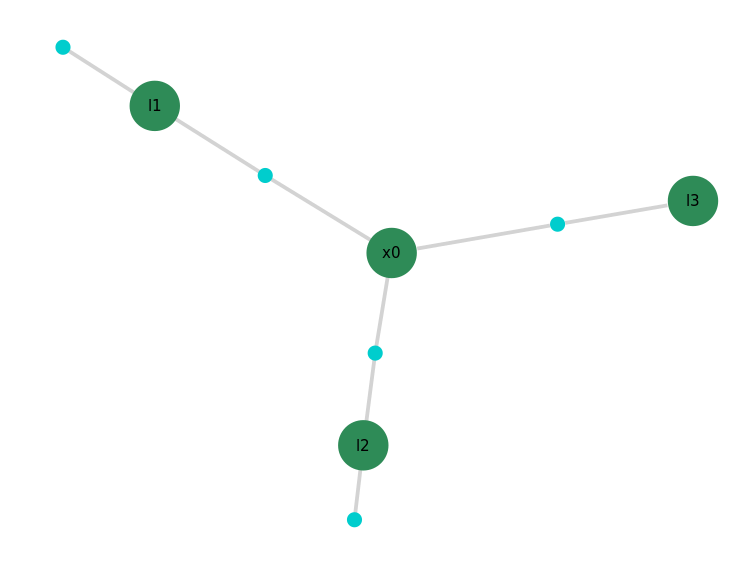

In [11]:
DFG.plotDFG(fg) # show the factor graph

The factor graph figure above shows the structure between variables and factors.

## Inference and Visualizations

At this point we can call the solver and interpret the first results:

In [ ]:
# the first run will be slow for JIT compilation to binary code (next runs are much faster)
solveGraph!(fg);

A set of tools are provided by the RoMEPlotting packages to show the numerical values contained in the factor graph solution.

First look at the two landmark positions `l1`, `l2` at `(10.0,30)`, `(30.0,-30)` respectively.

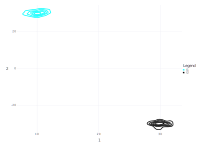

In [12]:
plotBelief(fg, [:l1;:l2], levels=5, c=["cyan"; "black"])

### First Location is Bi-Modal After Solve

Similarly, the belief estimate for the first vehicle position `x0` is bi-modal, due to the intersection of two range measurements:

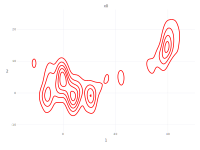

In [13]:
plotBelief(fg, :x0, levels=5, c=["red"])

Note, the first 'robot' positon in this localization and mapping problem is not associated with by a prior factor of any kind.  The initial position could have been anywhere, but the two range measurements to known landmarks limited the uncertainty as shown in the plot above.

### Non-Gaussian Estimate of the Unknown Beacon `l3`

In contrast to the known beacons `l1` and `l2` which have unimodal position estimates in the solution (owing to the prior information/assumptions on each), the belief over the position of unknown landmark `l3` is simultaneously resolved to a posterior estimate:

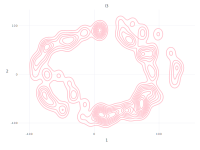

In [14]:
plotBelief(fg, :l3, levels=10, c=["pink"])

Notice how `l3`'s location belief (i.e. surveying/mapping) forms a ring around the only available measurement to `l3` from `x0`.  A unimodal solution for `l3` **does not exist**.  In conventional linear modeling, we might say the system is [singular](https://en.wikipedia.org/wiki/Invertible_matrix).

## Gaining and Losing Modes (i.e. Hypotheses)

Next consider the vehicle moving a distance of 50 units–-and by design the direction of travel is not known–-to the next true position. The video above gives away the vehicle position with the cyan line, showing travel in the shape of a lower case 'e'. The following function handles (pseudo odometry) factors as range-only between positions and range-only measurement factors to beacons as the vehice travels.

In [ ]:
# This is a helper function that simulates how the robot moves and measures between ground truth positions. 
function vehicle_drives!(fgl::G, from_lbl::Symbol, to_lbl::Symbol, GTp::Dict, GTl::Dict; measurelimit::R=150.0) where {G <: AbstractDFG, R <: Real}
  currvar = listVariables(fgl)
  if !(to_lbl in currvar)
    println("Adding new variable $to_lbl")
    addVariable!(fgl, to_lbl, Point2)
    # an odometry distance factor
    @show rho = norm(GTp[from_lbl] - GTp[to_lbl])
    ppr = Point2Point2Range( Normal(rho, 3.0) )
    addFactor!(fgl, [from_lbl;to_lbl], ppr)
  else
    @warn "Variable node $to_lbl already in the factor graph."
  end
  beacons = keys(GTl)
  for ll in beacons
    rho = norm(GTl[ll] - GTp[to_lbl])
    # Add measurements to beacons/landmarks if within limit
    if rho < measurelimit
      ppr = Point2Point2Range( Normal(rho, 3.0) )
      if !(ll in currvar)
        println("Adding variable vertex $ll, not yet in fgl<:AbstractDFG.")
        addVariable!(fgl, ll, Point2)
      end
      addFactor!(fgl, [to_lbl;ll], ppr)
    end
  end
  nothing
end

After running this function in Julia, a new member definition vehicle_drives_to! can be used line any other function. Julia will handle the just-in-time compiling for the type specific function required and cach the static code for repeat executions.

> **Note**, The exclamation mark at the end of the function is not reserved syntax in Julia, it's just part of the UTF character set.  The exclamation does, however, serve as a Julia community convention to tell the caller that this function will modify the contents of at least one of the variables being passed into it – in this case the factor graph `fg` will be modified!

Now the actual driving event can be added to the factor graph:

Adding new variable x1
rho = norm(GTp[from_lbl] - GTp[to_lbl]) = 50.0
Adding variable vertex l4, not yet in fgl<:AbstractDFG.
Adding new variable x2
rho = norm(GTp[from_lbl] - GTp[to_lbl]) = 50.0


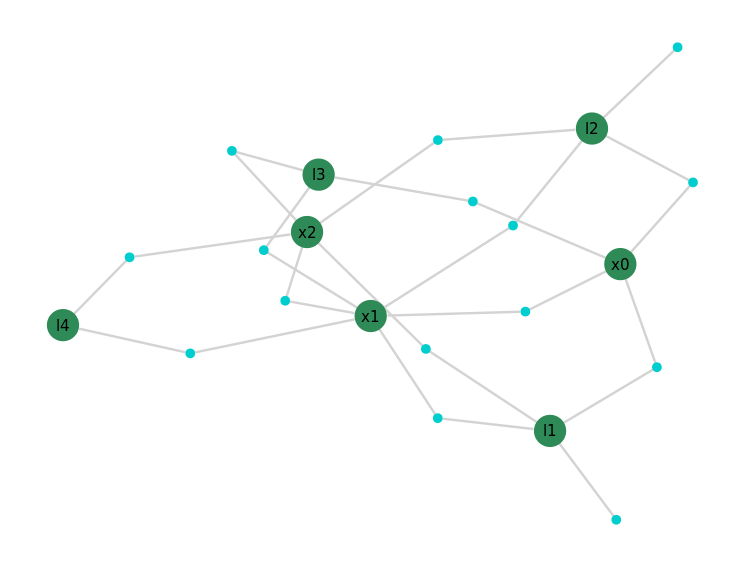

In [16]:
#drive to location :x1, then :x2
vehicle_drives!(fg, :x0, :x1, GTp, GTl)
vehicle_drives!(fg, :x1, :x2, GTp, GTl)

# see the graph
DFG.plotDFG(fg)

**Note**, the distance traveled could be any combination of accrued direction and speeds, however, a straight line Gaussian error model is used to keep the visual presentation of this example as simple as possible.

Lets solve the whole factor graph again.

In [ ]:
# solve the graph
solveGraph!(fg);

### Multi-Modal (i.e. Multi-Hypothesis) Solution

Now lets look at the robot position marginal beliefs.  We'll use a slightly lower level plotting function, `plotBelief`, to show the posterior beliefs of the tree robot locations:

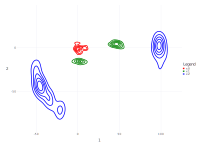

In [18]:
# plot robot positions, legacy signature `plotBelief = plotKDE``
plotBelief(fg, [:x0; :x1; :x2], levels=5, c=["red","green","blue"])

Notice how the robot trajectory has 2+ hypotheses,
- a) starting from `(0,0)` and traversing left to right, and 
- b) starting from `(50,-5)` and traversing left down.

Both are valid solutions!

### Resolving Estimates for New Beacons `l3` and `l4`

Let's look at how may measurements have so far been collected for the two unknown landmarks.  We'll use the `ls` function to see the connectivity between variables in the graph:

In [19]:
@show ls(fg, :l3);
@show ls(fg, :l4);

ls(fg, :l3) = [:x0l3f1, :x1l3f1, :x2l3f1]
ls(fg, :l4) = [:x1l4f1, :x2l4f1]


We therefore see that measurements to the **initially unknown beacons** are:
- ranges to `l3` were measured from all three robot positions `[x0,x1,x2]`, and
- ranges to `l4` were only mearured from two robot positions `[x1, x2]`

Can you guess what the posterior belief estimate on new beacons `l3` or `l4` are given the available information up this point?  Let's plot and see...

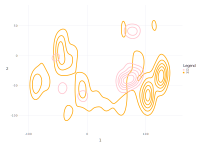

In [20]:
plotBelief(fg, [:l3;:l4], levels=5, c=["pink"; "orange"])

The two "free" beacons/landmarks `l3,l4` still have several modes each, implying insufficient data to constrain either to a conventional unimodal belief.

## Robot Moves Two More Positions

The robot drives further to collect more information, keeping in mind that so far that only the two known beacons `l1` and `l2` have unimodal posterior belief estimates!  All other variables in the system `[l3;l4; x0;x1;x2]` have multi-modal belief

In [ ]:
vehicle_drives!(fg, :x2, :x3, GTp, GTl)
vehicle_drives!(fg, :x3, :x4, GTp, GTl)

solveGraph!(fg);

### Estimating the Robot's Latest Position at `x3`, `x4`

After the above factor graph solution, the latest robot position belief estimate is 

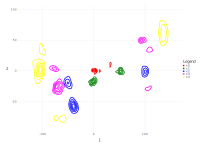

In [22]:
plotBelief(fg, [:x0;:x1;:x2;:x3;:x4], levels=5)

Notice how, even though several new range measurements were made, the posterior on `x3` has an increasing number of modes!  The number of modes may vary from solution to solution, but at least two dominant modes should be visible.

Modes are gained or lost based on a combination of the problem setup and nonparametric variations within each individual solve.  More dominant modes are more consistent, while 'weak' modes may come or go from one solve to the next.  If more compute resources are used, then more and more 'weaker' modes will be recovered.

> Several solver parameters can be modified to control the compute load vs. multimodal tracking efficacy.  Join the [Caesar.jl Slack](https://join.slack.com/t/caesarjl/shared_invite/zt-ucs06bwg-y2tEbddwX1vR18MASnOLsw) conversations, or connect with [NavAbility.io](https://www.navability.io/) to learn more.

The first robot position `[x0,x1]` belief estimates didn't change much with the addition new information!  There are still active hypotheses in the trajectory estimates going from `x0` to `x1`.  Perhaps the reason for that is because the new landmarks `[l3; l4]` are yet to be constrained to a low number of modes, lets see...

### Progress on Locating New Beacons `l3` and `l4`

We expect the uncertainty on position estimates for the initially unknown beacons `[l3;l4]` to decrease as new measurements are added to the overall problem.  Let's look again at the new posteriors on `l3` and `l4`:

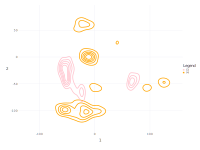

In [24]:
plotBelief(fg, [:l3;:l4], levels=5, c=["pink"; "orange"])

There are still multiple modes on both `l3` and `l4`!  We still have way too little information to resolve a unimodal estimate on either the robot positions or the new beacon locations!  The entire system remains underdetermined, i.e. singular!

### Moving to Positions `x5` and `x6`

The robot moves further through positions `x5` and `x6`, and let's solve again and look at the results:

In [ ]:
vehicle_drives!(fg, :x4, :x5, GTp, GTl)
vehicle_drives!(fg, :x5, :x6, GTp, GTl)

solveGraph!(fg);

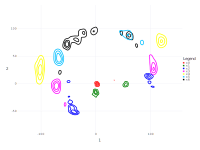

In [27]:
plotBelief(fg, [Symbol("x$i") for i=0:6], levels=3)

#### Reviewing Landmark Location Estimates Again

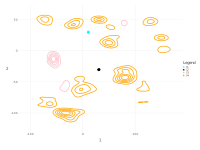

In [28]:
plotBelief(fg, [:l1;:l2;:l3;:l4], levels=5, c=["cyan";"black";"pink"; "orange"])

## Moving to Positions `x7` and `x8`

In [ ]:
vehicle_drives!(fg, :x6, :x7, GTp, GTl)
vehicle_drives!(fg, :x7, :x8, GTp, GTl)

In [35]:
solveGraph!(fg);

Building Bayes net...
Find potential functions for each clique


Using the list function, we can recover all the variables of interest, and then use for plotting:

lbls = sortDFG(ls(fg, r"x\d")) = [:x0, :x1, :x2, :x3, :x4, :x5, :x6, :x7, :x8]


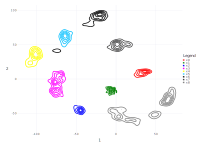

In [36]:
@show lbls = sortDFG(ls(fg, r"x\d"));
plotBelief(fg, lbls, levels=5)

Next we see a strong return to a single dominant mode in all vehicle position estimates, owing to the increased measurements to beacons/landmarks as well as more unimodal estimates in `l3, l4` beacon/landmark positions.

Several location belief estimates exhibit multimodality as the trajectory progresses (not shown), but collapses a stable set of dominant position estimates.  Landmark estimates are also stable at one estimate:

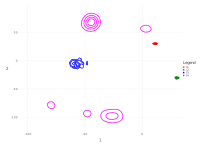

In [37]:
plotBelief(fg, [:l1;:l2;:l3;:l4], levels=4)

There is still multi-modality on landmark position estimates!  This indicates the uncertain nature of the problem which is driven by weak observabilty.

Let's also just look at what the factor graph looks like at this point:

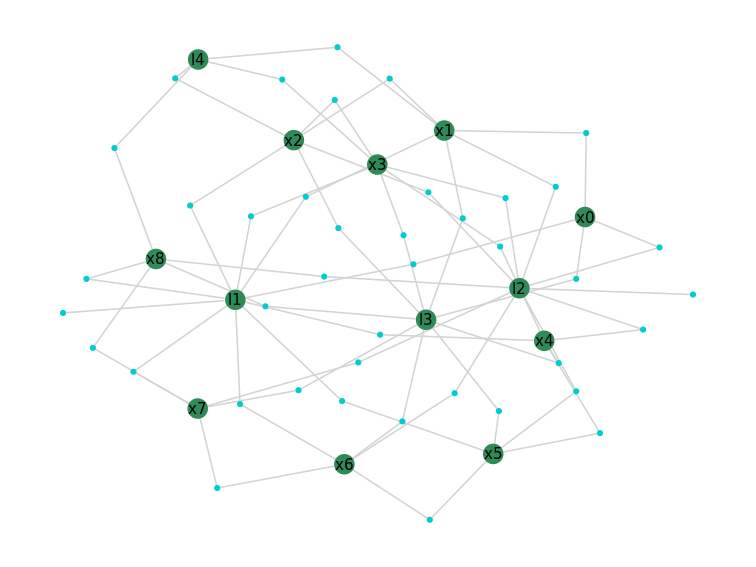

In [38]:
DFG.plotDFG(fg)

## Conclusion

Theoretically, should there be one or more overall trajectory hypotheses in the final result?

## Next Steps

- This Tutorial showed [one of four](https://juliarobotics.org/Caesar.jl/latest/concepts/why_nongaussian/) identified mechanisms how non-Gaussian behavior can enter a localization and mapping system.  See the other tutorials and material for similar discussions on other mechanism by which multi-modal posteriors manifest.
- For a longer version of this example, see [open-source solver documentation here](https://juliarobotics.org/Caesar.jl/latest/examples/basic_slamedonut/).

Visit [www.NavAbility.io](https://www.NavAbility.io) for more about how to use these and other advanced navigation features in your application.